In [1]:
import requests, zipfile, io
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import random
import tensorflow as tf
import time
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import categorical_crossentropy
import requests



# We're going to load in CIFAR10, a massive dataset with low resolution images in 10 categories. It's perfect for learning to build classifying ML models

In [2]:
data = tf.keras.datasets.cifar10.load_data()

### the categories are below, they're numbers in the dataset, so let's also keep track of the actual words

In [3]:
lbls_str = ("airplane automobile bird cat deer dog frog horse ship truck")

In [4]:
lbls_lst = lbls_str.split()
lbls_lst

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
(x_train, y_train), (x_test, y_test) = data

### there are 50k training images and 10k testing images, but we'll use only a few thousand so tests can be quick


In [6]:
for arr in [x_train, y_train, x_test, y_test ]:
    print(arr.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


### this histogram is a good idea because the training set's distribution should match the validation set's, and the validation set's should ABSOLUTELY match the test set's

### the splicing of the y_train below is a result of trying many different intervals, searching for histograms with more or less equal representation of all classes

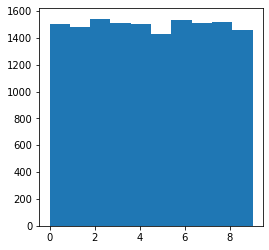

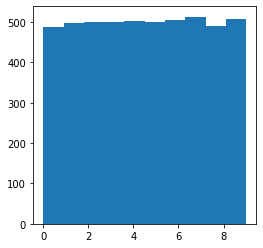

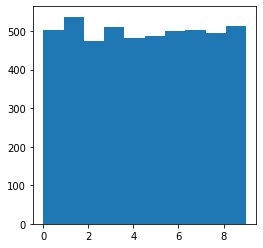

In [41]:
plt.figure(figsize=(4,4));
plt.hist(y_train[:15000]);

plt.show()
plt.figure(figsize=(4,4));
plt.hist(y_train[15000:20000]);

plt.show()
plt.figure(figsize=(4,4));
plt.hist(y_train[20000:25000]);

plt.show()

### this function will give us one hot vectors from the number corresponding to the classes, we know that  0 = airplane and 3 = cat, but the ML will have a better time if we have one hot vectors like <1,0,0,0,0,0,0,0,0,0> or <0,0,0,1,0,0,0,0,0,0>

In [42]:
def one_hot(vec):
    n = vec.shape[0]
    out = np.zeros((n, np.max(vec)+1))
    for i in range(n):
        out[i,vec[i][0]]=1
    return out

### let's look at an example to learn about one-hot

In [43]:
one_hot(np.array([[3],[5],[3],[0],[2],[1]]))

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

### using the intervals from earlier, we'll define a training, validation and testing set

(2000, 32, 32, 3) (2000, 1)


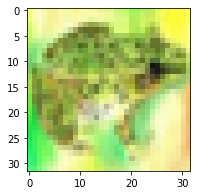

frog
(1000, 32, 32, 3) (1000, 1)


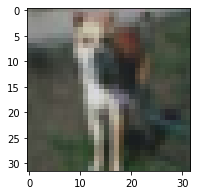

dog
(1000, 32, 32, 3) (1000, 1)


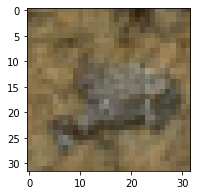

frog


In [44]:
xtr, xval, xtst = x_train[:2000],x_train[4500:5500],x_train[5500:6500]
ytr, yval, ytst = y_train[:2000],y_train[4500:5500],y_train[5500:6500]


for k in [(xtr,ytr),(xval,yval),(xtst,ytst)]:
    print(k[0].shape,k[1].shape)
    im = np.random.randint(0,500)
    #NOTE THAT THE IMAGES ARE 32 BY 32 BY 3 ARRAYS
    plt.figure(figsize=(3,3))
    plt.imshow(k[0][im])
    plt.show()
    print(lbls_lst[k[1][im][0]])

### it's always a good idea to save your work

In [45]:
vtr,vval,vtst = one_hot(ytr),one_hot(yval),one_hot(ytst)
np.save('xtr',xtr)
np.save('vtr',vtr)
np.save('xval',xval)
np.save('vval',vval)
np.save('xtst',xtst)
np.save('vtst',vtst)

## Let's build some AI models on this data

In [46]:
print('our whole training data has shape: ',xtr.shape)
print('\nand our training set of labels haa shape: ',vtr.shape)

our whole training data has shape:  (2000, 32, 32, 3)

and our training set of labels haa shape:  (2000, 10)


### we can start with a basic neural net, a function will help so we can make the AI model whenever and we don't have to copy code

In [57]:
def generate_basic_model(input_shape = xtr[0].shape):
    
    input_tensor = tf.keras.Input(shape=input_shape )
    #keras likes tensors
    #BTW A TENSOR IS ANY ARRAY AND OFTEN REFERS TO ARRAYS WITH MORE THAN 2 AXES 
    #e.g.:  rows, columns, color channels (RGB)
    #vectors are groups of number, matrices are groups of vectors, 
    #tensors are groups of matrices (or other tensors)
    #there's no need to be afraid of tensors
  
    flat= Flatten()(input_tensor)
    #neural nets like flat input, notice how the result of one line 
    #is the input to the next
    
    FC1 = Dense(64, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(1e-2))(flat)
    #cool kids use regularization
    #regularization helps prevent overfitting

    FC2 = Dense(32, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(1e-2))(FC1) 

    FC3 = Dense(16, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(1e-2))(FC2) 
    
    predictions = Dense(10, activation = 'softmax', 
                        kernel_regularizer = tf.keras.regularizers.L2(1e-2))(FC3)
    #connect model
    model = Model(inputs=input_tensor,outputs=predictions)
    #run
    model.compile(loss= categorical_crossentropy,
                  optimizer=Adam(learning_rate=1e-1),
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [58]:
basicAI = generate_basic_model()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                196672    
_________________________________________________________________
dense_33 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_34 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_35 (Dense)             (None, 10)                170       
Total params: 199,450
Trainable params: 199,450
Non-trainable params: 0
_____________________________________________________

### you just made an AI MODEL! now let's train it
#### Note that we use the variables 'vtr' and 'vval' for the labels, because the y values came as scalars

In [59]:
basicAI.fit(xtr, vtr, validation_data = (xval,vval), epochs = 15)

Epoch 1/15
63/63 [==============================] - 0s 3ms/step - loss: 1940.4546 - accuracy: 0.1035 - val_loss: 382.5786 - val_accuracy: 0.0900
Epoch 2/15
63/63 [==============================] - 0s 2ms/step - loss: 323.7853 - accuracy: 0.0960 - val_loss: 267.9725 - val_accuracy: 0.0900
Epoch 3/15
63/63 [==============================] - 0s 2ms/step - loss: 226.2558 - accuracy: 0.0935 - val_loss: 187.4725 - val_accuracy: 0.1090
Epoch 4/15
63/63 [==============================] - 0s 2ms/step - loss: 158.3020 - accuracy: 0.0925 - val_loss: 131.1658 - val_accuracy: 0.1090
Epoch 5/15
63/63 [==============================] - 0s 2ms/step - loss: 110.8016 - accuracy: 0.1005 - val_loss: 91.9026 - val_accuracy: 0.1090
Epoch 6/15
63/63 [==============================] - 0s 2ms/step - loss: 77.8198 - accuracy: 0.0905 - val_loss: 64.7677 - val_accuracy: 0.0980
Epoch 7/15
63/63 [==============================] - 0s 2ms/step - loss: 55.0794 - accuracy: 0.0960 - val_loss: 46.1043 - val_accuracy: 0.1

### and now let's try and predict an image's category (though accuracy is less than chance)

In [60]:
np.round(basicAI.predict(xval[305:310,:,:,:]),2),vval[305:310]

(array([[0.11, 0.09, 0.11, 0.1 , 0.09, 0.08, 0.1 , 0.09, 0.13, 0.09],
        [0.11, 0.09, 0.11, 0.1 , 0.09, 0.08, 0.1 , 0.09, 0.13, 0.09],
        [0.11, 0.09, 0.11, 0.1 , 0.09, 0.08, 0.1 , 0.09, 0.13, 0.09],
        [0.11, 0.09, 0.11, 0.1 , 0.09, 0.08, 0.1 , 0.09, 0.13, 0.09],
        [0.11, 0.09, 0.11, 0.1 , 0.09, 0.08, 0.1 , 0.09, 0.13, 0.09]],
       dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]))

### we might not be able to publish this model in Nature...
### let's try a convolutional neural network

In [82]:
def generate_conv_model(input_shape = xtr[0].shape):
    
    input_tensor = tf.keras.Input(shape=input_shape )
    
    #the kernel size will be set to 3 by 3 pixels
    #the 4, 8, and 12 in the next layers are the channels future layers will have
    #for example, the first layer here will make 4 convolutional filters that will 
    
    REG = 1e-2
    LR = 3e-1
    
    c1 = Conv2D(8, kernel_size=(3, 3),
                activation='relu', 
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.L2(REG))(input_tensor) 
    c2 = Conv2D(16, kernel_size=(3, 3),
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(REG))(c1)
    c3 = Conv2D(32, kernel_size=(3, 3),
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(REG))(c2)
    
    mp1 = tf.keras.layers.MaxPool2D()(c3)
    # max pooling layers can help convolutional models
    
    c4 = Conv2D(8, kernel_size=(3, 3),
                activation='relu', 
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.L2(REG))(mp1) 
    c5 = Conv2D(16, kernel_size=(3, 3),
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(REG))(c4)
    c6 = Conv2D(32, kernel_size=(3, 3), 
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(REG))(c5)
    
    mp2 = tf.keras.layers.MaxPool2D()(c6)
  
    flat= Flatten()(mp2)

    
    FC1 = Dense(64, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(REG))(flat)

    FC2 = Dense(32, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(REG))(FC1) 

    FC3 = Dense(16, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(REG))(FC2) 
    
    predictions = Dense(10, activation = 'softmax', 
                        kernel_regularizer = tf.keras.regularizers.L2(REG))(FC3)
    #connect model
    model = Model(inputs=input_tensor,outputs=predictions)
    #run
    model.compile(loss= categorical_crossentropy,
                  optimizer=Adam(learning_rate=LR),
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [106]:
convAI = generate_conv_model()

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_243 (Conv2D)          (None, 30, 30, 8)         224       
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_245 (Conv2D)          (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_246 (Conv2D)          (None, 11, 11, 8)         2312      
_________________________________________________________________
conv2d_247 (Conv2D)          (None, 9, 9, 16)          116

In [107]:
record = convAI.fit(xtr, vtr, validation_data = (xval,vval), epochs = 15)

Epoch 1/15
63/63 [==============================] - 2s 28ms/step - loss: 645241700352.0000 - accuracy: 0.0970 - val_loss: 523.0645 - val_accuracy: 0.1070
Epoch 2/15
63/63 [==============================] - 1s 23ms/step - loss: 554.9332 - accuracy: 0.1130 - val_loss: 558.3987 - val_accuracy: 0.0900
Epoch 3/15
63/63 [==============================] - 1s 21ms/step - loss: 412585.4375 - accuracy: 0.0985 - val_loss: 557.2830 - val_accuracy: 0.1090
Epoch 4/15
63/63 [==============================] - 1s 23ms/step - loss: 558.6328 - accuracy: 0.1030 - val_loss: 556.5317 - val_accuracy: 0.1120
Epoch 5/15
63/63 [==============================] - 1s 22ms/step - loss: 555.2888 - accuracy: 0.1070 - val_loss: 554.1161 - val_accuracy: 0.0900
Epoch 6/15
63/63 [==============================] - 1s 21ms/step - loss: 553.1525 - accuracy: 0.0925 - val_loss: 552.1649 - val_accuracy: 0.0900
Epoch 7/15
63/63 [==============================] - 1s 22ms/step - loss: 551.3725 - accuracy: 0.1000 - val_loss: 550.5

### This model also isn't fantastic. That's OK, though, testing architectures and hyperparameters is a natural step in ML/AI, let's explore the output of the 'fit' function which we stored in the 'record' variable

In [103]:
record.history

{'loss': [326.596923828125,
  323.2759094238281,
  320.1441955566406,
  317.127197265625,
  314.2469787597656,
  311.4796142578125,
  308.7980651855469,
  306.2056884765625,
  303.6790771484375,
  301.23663330078125,
  298.8390808105469,
  296.50994873046875,
  294.24139404296875,
  292.0055847167969,
  289.8309326171875],
 'accuracy': [0.09549999982118607,
  0.09549999982118607,
  0.09849999845027924,
  0.10199999809265137,
  0.09350000321865082,
  0.09049999713897705,
  0.10350000113248825,
  0.0925000011920929,
  0.10300000011920929,
  0.08900000154972076,
  0.09449999779462814,
  0.09399999678134918,
  0.09200000017881393,
  0.09200000017881393,
  0.1054999977350235],
 'val_loss': [324.8678894042969,
  321.6305236816406,
  318.56591796875,
  315.6544494628906,
  312.8025207519531,
  310.0709228515625,
  307.4455261230469,
  304.8768005371094,
  302.44061279296875,
  300.0013427734375,
  297.6070251464844,
  295.32061767578125,
  293.0699462890625,
  290.8716125488281,
  288.7245788

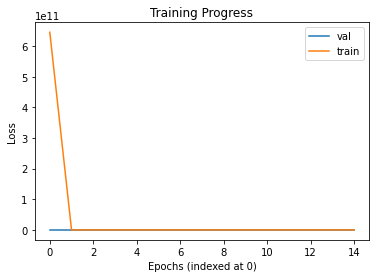

Text(0, 0.5, 'Accuracy (decimal)')

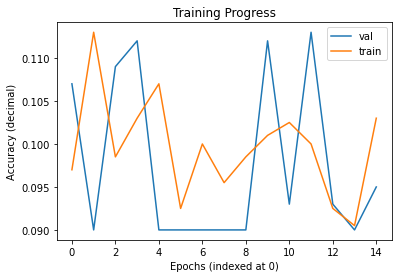

In [110]:
plt.plot(record.history['val_loss'])
plt.plot(record.history['loss'])
plt.title('Training Progress')
plt.xlabel('Epochs (indexed at 0)')
plt.ylabel('Loss')
plt.legend(['val','train'])
plt.show()

plt.plot(record.history['val_accuracy'])
plt.plot(record.history['accuracy'])
plt.legend(['val','train'])
plt.title('Training Progress')
plt.xlabel('Epochs (indexed at 0)')
plt.ylabel('Accuracy (decimal)')

In [88]:
def gen_model(lr =  1e-3, r = 1, input_shape = xtr[0].shape, 
              filter_size =3, fc_lst = [400,400,200], s = False):
    input_tensor = tf.keras.Input(shape=input_shape )
    """
    THIS ARCHITECTURE WAS INSPIRED BY VGG16 
    
    lr refers to learning rate
    r referes to L2 regularization rate 
    filter_size is used for vertical and horizontal dimension of all
        convolutional kernels in this model
    fc_lst defines the layers and cells following the convolutional 
        segment. For example, fc_lst = [400,200,100] will add three
        neural netowrk layers at the end of the model where the first
        has 400 cells and the last has 100 cells. 
        The final layer will always automatically have 10 cells for
        prediction and fc_lst must be a list of two or more numbers
    s takes a boolean deciding whether to print a keras summary
        of the model generated
    
    """
    c1 = Conv2D(8, kernel_size=(filter_size, filter_size), 
                padding='same',
                activation='relu', 
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.L2(r))(input_tensor) 
    c2 = Conv2D(8, kernel_size=(filter_size, filter_size),
                 padding='same',
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(r))(c1)
    c3 = Conv2D(8, kernel_size=(filter_size, filter_size), 
                 padding='same',
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(r))(c2)
    l1 = tf.keras.layers.LayerNormalization()(c3)
    c4 = Conv2D(16, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.L2(r))(l1) 
    c5 = Conv2D(16, kernel_size=(filter_size, filter_size),
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(r))(c4)
    c6 = Conv2D(16, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(r))(c5)
    mp2 = tf.keras.layers.MaxPool2D()(c6)
    l2 = tf.keras.layers.LayerNormalization()(mp2)
    c7 = Conv2D(32, kernel_size=(filter_size, filter_size),
                activation='relu', 
                input_shape=input_shape,
                kernel_regularizer = tf.keras.regularizers.L2(r))(l2) 
    c8 = Conv2D(32, kernel_size=(filter_size, filter_size),
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(r))(c7)
    c9 = Conv2D(32, kernel_size=(filter_size, filter_size), 
                activation='relu', 
                kernel_regularizer = tf.keras.regularizers.L2(r))(c8)
    mp3 = tf.keras.layers.MaxPool2D()(c9)
    l2 = tf.keras.layers.LayerNormalization()(mp3)
    ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ## FC ##
    flat= Flatten()(l2)
    for fc_dim in fc_lst[:-1]:
        FC = Dense(fc_dim, activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(r))(flat)
        flat = tf.keras.layers.LayerNormalization()(FC)
    flat = Dense(fc_lst[-1], activation = 'relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(r))(flat)    
    predictions = Dense(10, activation = 'softmax', 
                        kernel_regularizer = tf.keras.regularizers.L2(r))(flat)
    #connect model
    model = Model(inputs=input_tensor,outputs=predictions)
    #run
    model.compile(loss= categorical_crossentropy,
                  optimizer=Adam(learning_rate=lr),
                  metrics=['accuracy'])
    if s:
        model.summary()
    return model

### we can now easily generate different models
#### note that the summaries show 288 parameters after all the convolutions, so a number of cells much larger than that in the fc_lst may not be useful and could make the model slower with no benefit.
#### additionally, filter_size values above 4 will crash the model as the initial pixel count of 32 is too small to last through 9 such convolutions and a pair of max pooling layers

In [90]:
for fc_lst in [[200,200,200],[100,100],[200,150,150,50,50]]:
    model =gen_model(fc_lst = fc_lst,s=True)
    print('\n\n')

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_198 (Conv2D)          (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_199 (Conv2D)          (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_200 (Conv2D)          (None, 32, 32, 8)         584       
_________________________________________________________________
layer_normalization_90 (Laye (None, 32, 32, 8)         16        
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 30, 30, 16)        1168      
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 28, 28, 16)        232

In [117]:
for fc_lst in [[128,128,128],[64,64,32],[128,64,64,32,32]]:
    for filter_size in [2,3]:
        for i in range(3):
            #we will train every model 3 times with different learning rate and
            #regularization hyperparameters
            LRlog = np.random.rand()*3 - 4
            REGlog = np.random.rand()*3 - 3
            #note that this rand function gives a number from a uniform distribution
            #a number from a normal distribution wouldn't be ideal
            LR = 10**(LRlog)
            REG = 10**(REGlog)
            #we're exploring the hyperparemeter space of LR and REG
            #logarithmically, so various magnitudes are equally represented
            #if we took a random number from 1e-4 to 1e-1 directly, 
            #the lower magnitudes wouldn't come up often
            model =gen_model(fc_lst = fc_lst,
                             filter_size=filter_size,
                             lr= LR, r = REG, s=True)
            print('\nMODEL (fc_lst, filter_size, LR, REG): ',
                  fc_lst, filter_size, np.round(LR,5), np.round(REG,4),
                 '\n\n')
            #the np.round() function is fantastic for the eyes
            record = model.fit(xtr,vtr,validation_data=(xval,vval), epochs = 8)
            

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_312 (Conv2D)          (None, 32, 32, 8)         104       
_________________________________________________________________
conv2d_313 (Conv2D)          (None, 32, 32, 8)         264       
_________________________________________________________________
conv2d_314 (Conv2D)          (None, 32, 32, 8)         264       
_________________________________________________________________
layer_normalization_150 (Lay (None, 32, 32, 8)         16        
_________________________________________________________________
conv2d_315 (Conv2D)          (None, 31, 31, 16)        528       
_________________________________________________________________
conv2d_316 (Conv2D)          (None, 30, 30, 16)        104

Epoch 4/8
63/63 [==============================] - 8s 120ms/step - loss: 2.3044 - accuracy: 0.1050 - val_loss: 2.3030 - val_accuracy: 0.0900
Epoch 5/8
63/63 [==============================] - 7s 112ms/step - loss: 2.3030 - accuracy: 0.1070 - val_loss: 2.3025 - val_accuracy: 0.0900
Epoch 6/8
63/63 [==============================] - 6s 97ms/step - loss: 2.3027 - accuracy: 0.1070 - val_loss: 2.3025 - val_accuracy: 0.0900
Epoch 7/8
63/63 [==============================] - 8s 125ms/step - loss: 2.3027 - accuracy: 0.1070 - val_loss: 2.3026 - val_accuracy: 0.0900
Epoch 8/8
63/63 [==============================] - 5s 87ms/step - loss: 2.3035 - accuracy: 0.1070 - val_loss: 2.3028 - val_accuracy: 0.0900
Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_330 (Con

63/63 [==============================] - 14s 146ms/step - loss: 74.7595 - accuracy: 0.1015 - val_loss: 42.8821 - val_accuracy: 0.0940
Epoch 2/8
63/63 [==============================] - 7s 115ms/step - loss: 27.1269 - accuracy: 0.1435 - val_loss: 15.5686 - val_accuracy: 0.1870
Epoch 3/8
63/63 [==============================] - 7s 104ms/step - loss: 10.4519 - accuracy: 0.1835 - val_loss: 6.7268 - val_accuracy: 0.2120
Epoch 4/8
63/63 [==============================] - 7s 104ms/step - loss: 5.1569 - accuracy: 0.1920 - val_loss: 4.0865 - val_accuracy: 0.1710
Epoch 5/8
63/63 [==============================] - 7s 114ms/step - loss: 3.5218 - accuracy: 0.1915 - val_loss: 3.1217 - val_accuracy: 0.2160
Epoch 6/8
63/63 [==============================] - 7s 119ms/step - loss: 2.9538 - accuracy: 0.1910 - val_loss: 2.8498 - val_accuracy: 0.1650
Epoch 7/8
63/63 [==============================] - 9s 140ms/step - loss: 2.7643 - accuracy: 0.1640 - val_loss: 2.6729 - val_accuracy: 0.1780
Epoch 8/8
63/63 [

63/63 [==============================] - 13s 136ms/step - loss: 9.2770 - accuracy: 0.1000 - val_loss: 3.3874 - val_accuracy: 0.0950
Epoch 2/8
63/63 [==============================] - 9s 137ms/step - loss: 2.7932 - accuracy: 0.0900 - val_loss: 2.4944 - val_accuracy: 0.0900
Epoch 3/8
63/63 [==============================] - 8s 126ms/step - loss: 2.4150 - accuracy: 0.0930 - val_loss: 2.3615 - val_accuracy: 0.0900
Epoch 4/8
63/63 [==============================] - 9s 149ms/step - loss: 2.3399 - accuracy: 0.0980 - val_loss: 2.3233 - val_accuracy: 0.0900
Epoch 5/8
63/63 [==============================] - 8s 134ms/step - loss: 2.3167 - accuracy: 0.1070 - val_loss: 2.3109 - val_accuracy: 0.0900
Epoch 6/8
63/63 [==============================] - 6s 101ms/step - loss: 2.3085 - accuracy: 0.1070 - val_loss: 2.3058 - val_accuracy: 0.0900
Epoch 7/8
63/63 [==============================] - 7s 106ms/step - loss: 2.3053 - accuracy: 0.1070 - val_loss: 2.3040 - val_accuracy: 0.0900
Epoch 8/8
63/63 [=====

63/63 [==============================] - 13s 125ms/step - loss: 12.1314 - accuracy: 0.0985 - val_loss: 2.4224 - val_accuracy: 0.0930
Epoch 2/8
63/63 [==============================] - 6s 93ms/step - loss: 2.3346 - accuracy: 0.0960 - val_loss: 2.3198 - val_accuracy: 0.1090
Epoch 3/8
63/63 [==============================] - 5s 84ms/step - loss: 2.3312 - accuracy: 0.0900 - val_loss: 2.3164 - val_accuracy: 0.0950
Epoch 4/8
63/63 [==============================] - 7s 109ms/step - loss: 2.3306 - accuracy: 0.1020 - val_loss: 2.3095 - val_accuracy: 0.1090
Epoch 5/8
63/63 [==============================] - 8s 121ms/step - loss: 2.3182 - accuracy: 0.0835 - val_loss: 2.3107 - val_accuracy: 0.1120
Epoch 6/8
63/63 [==============================] - 6s 99ms/step - loss: 2.3134 - accuracy: 0.0900 - val_loss: 2.3093 - val_accuracy: 0.0900
Epoch 7/8
63/63 [==============================] - 6s 99ms/step - loss: 2.3114 - accuracy: 0.0860 - val_loss: 2.3129 - val_accuracy: 0.0900
Epoch 8/8
63/63 [========

Epoch 1/8
63/63 [==============================] - 15s 128ms/step - loss: 13.9032 - accuracy: 0.1175 - val_loss: 13.3876 - val_accuracy: 0.1160
Epoch 2/8
63/63 [==============================] - 6s 89ms/step - loss: 12.9188 - accuracy: 0.1380 - val_loss: 12.4372 - val_accuracy: 0.1620
Epoch 3/8
63/63 [==============================] - 6s 87ms/step - loss: 11.9829 - accuracy: 0.1665 - val_loss: 11.5319 - val_accuracy: 0.1550
Epoch 4/8
63/63 [==============================] - 8s 121ms/step - loss: 11.1304 - accuracy: 0.1845 - val_loss: 10.7622 - val_accuracy: 0.1760
Epoch 5/8
63/63 [==============================] - 9s 140ms/step - loss: 10.3785 - accuracy: 0.2220 - val_loss: 10.0490 - val_accuracy: 0.2230
Epoch 6/8
63/63 [==============================] - 9s 138ms/step - loss: 9.7184 - accuracy: 0.2150 - val_loss: 9.4311 - val_accuracy: 0.2140
Epoch 7/8
63/63 [==============================] - 7s 114ms/step - loss: 9.1067 - accuracy: 0.2340 - val_loss: 8.8730 - val_accuracy: 0.2370
Epoc

63/63 [==============================] - 14s 152ms/step - loss: 2.7729 - accuracy: 0.0980 - val_loss: 2.6568 - val_accuracy: 0.0900
Epoch 2/8
63/63 [==============================] - 9s 144ms/step - loss: 2.5918 - accuracy: 0.1000 - val_loss: 2.5339 - val_accuracy: 0.0900
Epoch 3/8
63/63 [==============================] - 9s 147ms/step - loss: 2.4936 - accuracy: 0.1070 - val_loss: 2.4574 - val_accuracy: 0.0900
Epoch 4/8
63/63 [==============================] - 10s 156ms/step - loss: 2.4320 - accuracy: 0.1050 - val_loss: 2.4087 - val_accuracy: 0.0900
Epoch 5/8
63/63 [==============================] - 8s 131ms/step - loss: 2.3924 - accuracy: 0.0995 - val_loss: 2.3759 - val_accuracy: 0.0900
Epoch 6/8
63/63 [==============================] - 9s 147ms/step - loss: 2.3649 - accuracy: 0.1060 - val_loss: 2.3545 - val_accuracy: 0.0900
Epoch 7/8
63/63 [==============================] - 9s 139ms/step - loss: 2.3468 - accuracy: 0.1070 - val_loss: 2.3394 - val_accuracy: 0.0900
Epoch 8/8
63/63 [====

63/63 [==============================] - 14s 134ms/step - loss: 75.2258 - accuracy: 0.1115 - val_loss: 70.1936 - val_accuracy: 0.1500
Epoch 2/8
63/63 [==============================] - 7s 113ms/step - loss: 65.8700 - accuracy: 0.1310 - val_loss: 61.6191 - val_accuracy: 0.1120
Epoch 3/8
63/63 [==============================] - 8s 126ms/step - loss: 57.9270 - accuracy: 0.1310 - val_loss: 54.2666 - val_accuracy: 0.1400
Epoch 4/8
63/63 [==============================] - 6s 93ms/step - loss: 51.1517 - accuracy: 0.1695 - val_loss: 48.0705 - val_accuracy: 0.1830
Epoch 5/8
63/63 [==============================] - 6s 91ms/step - loss: 45.4266 - accuracy: 0.1795 - val_loss: 42.8090 - val_accuracy: 0.1990
Epoch 6/8
63/63 [==============================] - 7s 108ms/step - loss: 40.5314 - accuracy: 0.2050 - val_loss: 38.3170 - val_accuracy: 0.2150
Epoch 7/8
63/63 [==============================] - 8s 127ms/step - loss: 36.3635 - accuracy: 0.2320 - val_loss: 34.4737 - val_accuracy: 0.2600
Epoch 8/8


63/63 [==============================] - 14s 144ms/step - loss: 3.2599 - accuracy: 0.0935 - val_loss: 3.1475 - val_accuracy: 0.0950
Epoch 2/8
63/63 [==============================] - 8s 131ms/step - loss: 3.0897 - accuracy: 0.0955 - val_loss: 3.0395 - val_accuracy: 0.0980
Epoch 3/8
63/63 [==============================] - 8s 129ms/step - loss: 2.9882 - accuracy: 0.1035 - val_loss: 2.9432 - val_accuracy: 0.0900
Epoch 4/8
63/63 [==============================] - 9s 143ms/step - loss: 2.9040 - accuracy: 0.1070 - val_loss: 2.8654 - val_accuracy: 0.0900
Epoch 5/8
63/63 [==============================] - 10s 154ms/step - loss: 2.8310 - accuracy: 0.1070 - val_loss: 2.7972 - val_accuracy: 0.0900
Epoch 6/8
63/63 [==============================] - 8s 134ms/step - loss: 2.7669 - accuracy: 0.1070 - val_loss: 2.7374 - val_accuracy: 0.0900
Epoch 7/8
63/63 [==============================] - 8s 132ms/step - loss: 2.7107 - accuracy: 0.1070 - val_loss: 2.6849 - val_accuracy: 0.0900
Epoch 8/8
63/63 [====

63/63 [==============================] - 20s 195ms/step - loss: 6.0142 - accuracy: 0.1100 - val_loss: 5.6089 - val_accuracy: 0.1110
Epoch 2/8
63/63 [==============================] - 11s 175ms/step - loss: 5.2906 - accuracy: 0.1130 - val_loss: 4.9719 - val_accuracy: 0.1370
Epoch 3/8
63/63 [==============================] - 11s 175ms/step - loss: 4.6933 - accuracy: 0.1440 - val_loss: 4.3898 - val_accuracy: 0.2220
Epoch 4/8
63/63 [==============================] - 11s 173ms/step - loss: 4.2135 - accuracy: 0.1795 - val_loss: 3.9985 - val_accuracy: 0.1640
Epoch 5/8
63/63 [==============================] - 11s 178ms/step - loss: 3.8839 - accuracy: 0.1790 - val_loss: 3.7072 - val_accuracy: 0.2410
Epoch 6/8
63/63 [==============================] - 10s 157ms/step - loss: 3.5646 - accuracy: 0.2115 - val_loss: 3.4653 - val_accuracy: 0.2160
Epoch 7/8
63/63 [==============================] - 9s 142ms/step - loss: 3.3031 - accuracy: 0.2475 - val_loss: 3.2429 - val_accuracy: 0.2490
Epoch 8/8
63/63 [

## Now THOSE are some GOOOOD models!!